In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Data Loading
Here we are using 'Brazilian E-Commerce Public Dataset by Olist'. You can download the dataset here: https://www.kaggle.com/olistbr/brazilian-ecommerce

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.

Here, we are going to analyze sales orders monthly, weekly, daily and validate different prediction models to find out which model is the most suitable for this dataset.


In [2]:
#Load orders
orders =  pd.read_csv('olist_orders_dataset.csv')

In [3]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


#### Each order consists of multiple order items, let's merge these files to get details about order items like price of product, freight value etc.

In [4]:
#Load order items
order_items  = pd.read_csv('olist_order_items_dataset.csv')
order_items.head(5)

,order_id,order_item_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [5]:
#Merge orders with order items
order_merged = pd.merge(orders, order_items, how= 'inner', on= 'order_id')
order_merged.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,19.90,8.72
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,1,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,147.90,27.36
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,1,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,49.90,16.05
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00,1,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,59.99,15.17
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00,1,ac1789e492dcd698c5c10b97a671243a,63b9ae557efed31d1f7687917d248a8d,19.90,16.05
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00,1,9a78fb9862b10749a117f7fc3c31f051,7c67e1448b00f6e969d365cea6b010ab,149.99,19.77


**Freight price is  transportation cost which varies according to product and location of seller as well as customer.**

Total Price of product = sales price + freight

So, let's create new column to get 'Total Price'

In [6]:
#Create Total Price column
order_merged['Total Price'] = pd.to_numeric(order_merged['price'])+ pd.to_numeric(order_merged['freight_value'])

In [7]:
order_merged.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,price,freight_value,Total Price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,179.12


#### Each product belongs to a product category. Let's find product category for each product.

In [19]:
#Load product data
product_cat = pd.read_csv('olist_products_dataset.csv')
product_cat.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


#### There is also a file available which consists of product category translated from Portugese to english.

In [20]:
#Load product category translated file
cat_eng = pd.read_csv('product_category_name_translation.csv')
cat_eng.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


#### Let's join above files to get translated product category names.

In [21]:
#Join Producr category names
product_merged = pd.merge(product_cat,cat_eng,how='left',on='product_category_name' )
product_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
product_id                       32951 non-null object
product_category_name            32341 non-null object
product_name_lenght              32341 non-null float64
product_description_lenght       32341 non-null float64
product_photos_qty               32341 non-null float64
product_weight_g                 32949 non-null float64
product_length_cm                32949 non-null float64
product_height_cm                32949 non-null float64
product_width_cm                 32949 non-null float64
product_category_name_english    32328 non-null object
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


#### Let's see if any product category name is missing in product dataframe.

In [22]:
#Find missing product categories
nan = product_merged[product_merged['product_category_name'].isna()]
nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 105 to 32852
Data columns (total 10 columns):
product_id                       610 non-null object
product_category_name            0 non-null object
product_name_lenght              0 non-null float64
product_description_lenght       0 non-null float64
product_photos_qty               0 non-null float64
product_weight_g                 609 non-null float64
product_length_cm                609 non-null float64
product_height_cm                609 non-null float64
product_width_cm                 609 non-null float64
product_category_name_english    0 non-null object
dtypes: float64(7), object(3)
memory usage: 52.4+ KB


#### Now we need to check if all english translation is present for product categories.

In [23]:
#Check missing values in translated file
nan_eng = product_merged[(product_merged['product_category_name_english'].isna()==True) & (product_merged['product_category_name'].isna()==False)]
nan_eng

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
1628,0105b5323d24fc655f73052694dbbb3a,pc_gamer,59.0,621.0,4.0,2839.0,19.0,16.0,18.0,NaN
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0,NaN
7478,6727051471a0fc4a0e7737b57bff2549,pc_gamer,60.0,1532.0,3.0,650.0,16.0,22.0,20.0,NaN
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0,NaN
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0,NaN
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0,NaN
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,NaN
16930,dbe520fb381ad695a7e1f2807d20c765,pc_gamer,60.0,840.0,6.0,800.0,18.0,22.0,22.0,NaN
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,NaN


We find that two product categories: ***'portateis_cozinha_e_preparadores_de_alimentos'*** and ***'pc_gamer'*** arenot translated.
So let's translate them and add in dataframe.

In [24]:
#Add missing translations
product_merged['product_category_name_english']= np.where(product_merged['product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos',
         "portable kitchen_and_food_preparators",product_merged['product_category_name_english'])


In [54]:
product_merged['product_category_name_english']= np.where(product_merged['product_category_name']=='pc_gamer',
         "pc_gamer",product_merged['product_category_name_english'])

In [55]:
#Check if missing values are filled
product_merged[(product_merged['product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos')]


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
5821,6fd83eb3e0799b775e4f946bd66657c0,portateis_cozinha_e_preparadores_de_alimentos,52.0,280.0,1.0,1200.0,25.0,33.0,25.0,portable kitchen_and_food_preparators
7325,5d923ead886c44b86845f69e50520c3e,portateis_cozinha_e_preparadores_de_alimentos,58.0,284.0,1.0,1200.0,25.0,33.0,25.0,portable kitchen_and_food_preparators
8819,bed164d9d628cf0593003389c535c6e0,portateis_cozinha_e_preparadores_de_alimentos,54.0,382.0,2.0,850.0,30.0,21.0,22.0,portable kitchen_and_food_preparators
11039,1220978a08a6b29a202bc015b18250e9,portateis_cozinha_e_preparadores_de_alimentos,46.0,280.0,1.0,1200.0,25.0,33.0,25.0,portable kitchen_and_food_preparators
14266,ae62bb0f95af63d64eae5f93dddea8d3,portateis_cozinha_e_preparadores_de_alimentos,59.0,927.0,1.0,10600.0,40.0,20.0,38.0,portable kitchen_and_food_preparators
16182,1954739d84629e7323a4295812a3e0ec,portateis_cozinha_e_preparadores_de_alimentos,58.0,792.0,4.0,750.0,30.0,30.0,30.0,portable kitchen_and_food_preparators
17800,c7a3f1a7f9eef146cc499368b578b884,portateis_cozinha_e_preparadores_de_alimentos,52.0,1372.0,5.0,7350.0,40.0,30.0,23.0,portable kitchen_and_food_preparators
18610,7afdd65f79f63819ff5bee328843fa37,portateis_cozinha_e_preparadores_de_alimentos,48.0,305.0,1.0,750.0,20.0,20.0,20.0,portable kitchen_and_food_preparators
26890,a4756663d007b0cd1af865754d08d968,portateis_cozinha_e_preparadores_de_alimentos,60.0,1304.0,4.0,650.0,22.0,6.0,14.0,portable kitchen_and_food_preparators
29919,cb9d764f38ee4d0c00af64d5c388f837,portateis_cozinha_e_preparadores_de_alimentos,57.0,306.0,1.0,625.0,28.0,27.0,24.0,portable kitchen_and_food_preparators


#### Let's fill unavailable product categories by 'unknown'

In [25]:
#Fill rest of missing values where you don't have any product vategory in English and Portugese by 'unknown'
product_merged.loc[product_merged['product_category_name'].isna(), 'product_category_name'] = 'unknown'
product_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
product_id                       32951 non-null object
product_category_name            32951 non-null object
product_name_lenght              32341 non-null float64
product_description_lenght       32341 non-null float64
product_photos_qty               32341 non-null float64
product_weight_g                 32949 non-null float64
product_length_cm                32949 non-null float64
product_height_cm                32949 non-null float64
product_width_cm                 32949 non-null float64
product_category_name_english    32338 non-null object
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


#### Fill the missing product categories english translation as 'unknown' also.

In [26]:
product_merged.loc[product_merged['product_category_name_english'].isna(), 'product_category_name_english'] = 'unknown'
product_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
product_id                       32951 non-null object
product_category_name            32951 non-null object
product_name_lenght              32341 non-null float64
product_description_lenght       32341 non-null float64
product_photos_qty               32341 non-null float64
product_weight_g                 32949 non-null float64
product_length_cm                32949 non-null float64
product_height_cm                32949 non-null float64
product_width_cm                 32949 non-null float64
product_category_name_english    32951 non-null object
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


#### Let's see all unique catgories we have:

In [27]:
#Get unique categories
product_merged['product_category_name_english'].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'unknown', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
     

#### Product categories by value counts:

In [28]:
#Category by sales
product_merged['product_category_name'].value_counts()

cama_mesa_banho                                  3029
esporte_lazer                                    2867
moveis_decoracao                                 2657
beleza_saude                                     2444
utilidades_domesticas                            2335
automotivo                                       1900
informatica_acessorios                           1639
brinquedos                                       1411
relogios_presentes                               1329
telefonia                                        1134
bebes                                             919
perfumaria                                        868
papelaria                                         849
fashion_bolsas_e_acessorios                       849
cool_stuff                                        789
ferramentas_jardim                                753
pet_shop                                          719
unknown                                           610
eletronicos                 

#### Finally merge the dataframe with order dataframe to get all information together.

In [29]:
#Merge order, product dataframe
order_prod = pd.merge(order_merged,product_merged, how='left', on='product_id')

In [30]:
order_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 23 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_status                     112650 non-null object
order_purchase_timestamp         112650 non-null object
order_approved_at                112635 non-null object
order_delivered_carrier_date     111456 non-null object
order_delivered_customer_date    110196 non-null object
order_estimated_delivery_date    112650 non-null object
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
seller_id                        112650 non-null object
price                            112650 non-null float64
freight_value                    112650 non-null float64
Total Price                      112650 non-null float64
product_category_name            112650 non-null object
product_name_lenght              111047 non-nul

#### Now let's select columns which may be relevant and important for predicting sales.

In [31]:
#Select required columns
order1 = order_prod[['order_id','customer_id','order_purchase_timestamp','product_id','product_category_name_english','product_photos_qty','product_description_lenght','price','freight_value','Total Price' ]]

#### We also have cutomer dataset, it will give us information about customer location(city, state, zip code etc)

In [34]:
#Get customer data
cust = pd.read_csv('olist_customers_dataset.csv')
cust.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [35]:
len(cust.customer_zip_code_prefix.unique())

14994

#### Merge the customer dataframe with order1 to join customer data to order, product data

In [36]:
#Merge with customer dataframe
order2 = pd.merge(order1,cust,how='inner', on='customer_id')

In [37]:
order2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 14 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_purchase_timestamp         112650 non-null object
product_id                       112650 non-null object
product_category_name_english    112650 non-null object
product_photos_qty               111047 non-null float64
product_description_lenght       111047 non-null float64
price                            112650 non-null float64
freight_value                    112650 non-null float64
Total Price                      112650 non-null float64
customer_unique_id               112650 non-null object
customer_zip_code_prefix         112650 non-null int64
customer_city                    112650 non-null object
customer_state                   112650 non-null object
dtypes: float64(5), int64(1), object(8)
memory usage: 12.9+ MB


In [67]:
order2.head(5)

,order_id,customer_id,order_purchase_timestamp,product_id,product_category_name_english,product_photos_qty,product_description_lenght,price,freight_value,Total Price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,housewares,4.0,268.0,29.99,8.72,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,perfumery,1.0,178.0,118.70,22.76,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,auto,1.0,232.0,159.90,19.22,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,3.0,468.0,45.00,27.20,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,stationery,4.0,316.0,19.90,8.72,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


#### Now we need to convert purchase timestamp to datetime so that we can group by based on month, week or day

In [38]:
#Convert string to datetime
order2['order_purchase_timestamp'] =  pd.to_datetime(order2['order_purchase_timestamp'], format='%Y%m%d %H:%M:%S')

In [39]:
order2.head(5)

,order_id,customer_id,order_purchase_timestamp,product_id,product_category_name_english,product_photos_qty,product_description_lenght,price,freight_value,Total Price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,housewares,4.0,268.0,29.99,8.72,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,perfumery,1.0,178.0,118.70,22.76,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,auto,1.0,232.0,159.90,19.22,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,3.0,468.0,45.00,27.20,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,stationery,4.0,316.0,19.90,8.72,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [41]:
#Convert into year, month and day
order2['year'] ,  order2['month'],  order2['day'] = order2['order_purchase_timestamp'].dt.year, order2['order_purchase_timestamp'].dt.month, order2['order_purchase_timestamp'].dt.day
    

In [42]:
order2.head(5)

,order_id,customer_id,order_purchase_timestamp,product_id,product_category_name_english,product_photos_qty,product_description_lenght,price,freight_value,Total Price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year,month,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,housewares,4.0,268.0,29.99,8.72,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,perfumery,1.0,178.0,118.70,22.76,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,auto,1.0,232.0,159.90,19.22,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,3.0,468.0,45.00,27.20,72.20,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,stationery,4.0,316.0,19.90,8.72,28.62,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,13


#### Convert 'product_category_name_english' data type from 'String' to 'Category' and assign them codes for easier data analysis

In [44]:
#Encode category
order2["product_category_name_english"] = order2["product_category_name_english"].astype('category')
order2["prod_cat_eng"] = order2["product_category_name_english"].cat.codes


#### Let's map the co-relation metrix to find most important variables for predicting sales.

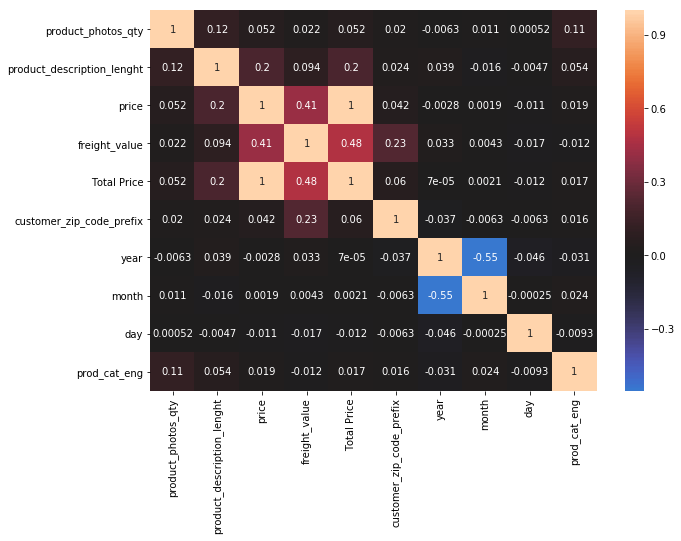

In [46]:
#Draw co-relation metrix
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(order2.corr(), ax=ax, annot=True, center = 0)

As we see above, some important relations are:

1. Price is directly related to total price which is expected
2. Freight values is strongly related to Total Price
3. Product freight_value is related to zip_code_prefix by weak co-relation
4. Product desciption length is related to price by weak co-relation
5. There is very weak co-relation between Product_category_english to product desciption length and product_photos_quantity.   

In [74]:
order2.head(3)

,order_id,customer_id,order_purchase_timestamp,product_id,product_category_name_english,product_photos_qty,product_description_lenght,price,freight_value,Total Price,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year,month,day,prod_cat_eng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,housewares,4.0,268.0,29.99,8.72,38.71,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2,49
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,perfumery,1.0,178.0,118.70,22.76,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,24,60
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,auto,1.0,232.0,159.90,19.22,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,8,5


Now, from co-relation chart 'product_category_name_english' is not strongly related to 'Total Price' which is not I expected, so we need to make sure that is truely the case.
Let's plot distribution of sales by product category.

C:\Users\Snigdha\AppData\Local\conda\conda\envs\neuralnets\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


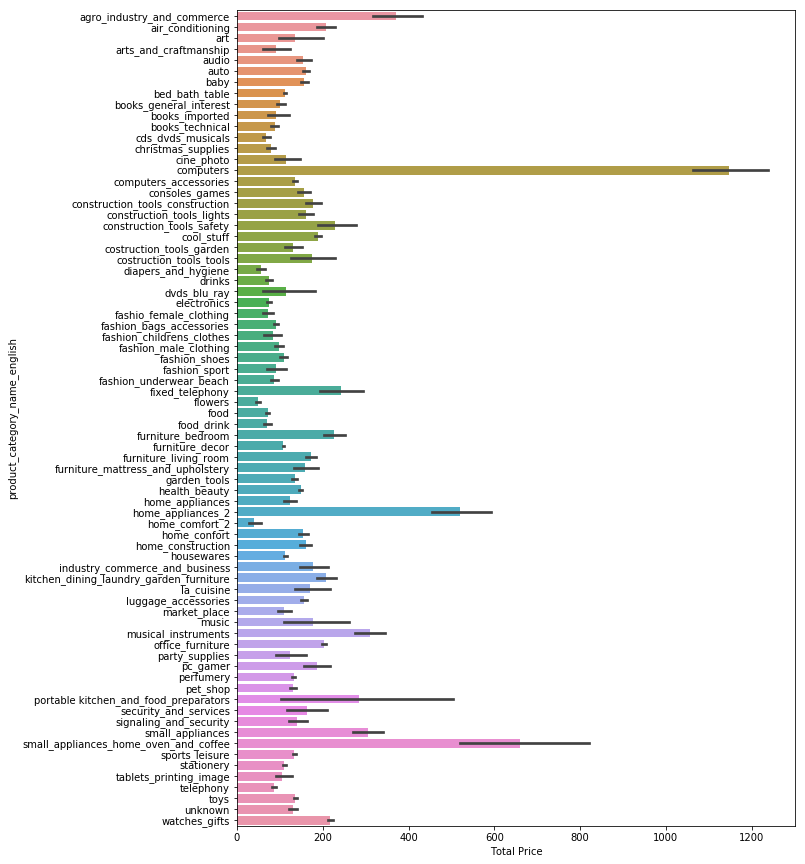

In [75]:
fig, ax = plt.subplots(figsize=(10,15))  
sns.barplot(order2['Total Price'], order2.product_category_name_english, ax=ax)

As seen above there are mainly 3 categories: computers, home_appliances_2 and small_appliences_home_oven_and_coffee which have much higher sales than other categories.

This explains the weak relationship as only 3 out of 74 categories shows distict price.

One approch to this situation would be to group above three categories together in one group and keep the rest of categories in another group and to predict total sales for each group.

The main reason for grouping is to get maximum data points as possible. 


In [49]:
#Convert datetime to date
order2['date'] = order2['order_purchase_timestamp'].dt.date

In [50]:
order2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 19 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_purchase_timestamp         112650 non-null datetime64[ns]
product_id                       112650 non-null object
product_category_name_english    112650 non-null category
product_photos_qty               111047 non-null float64
product_description_lenght       111047 non-null float64
price                            112650 non-null float64
freight_value                    112650 non-null float64
Total Price                      112650 non-null float64
customer_unique_id               112650 non-null object
customer_zip_code_prefix         112650 non-null int64
customer_city                    112650 non-null object
customer_state                   112650 non-null object
year                             112650 non-null int64
month                            112

#### To aggregate sales by date convert datetime to date

In [51]:
#Groupby by date
order3 = order2[['date','Total Price']]
order3= order3.groupby(['date'],sort = True).sum()
order3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 616 entries, 2016-09-04 to 2018-09-03
Data columns (total 1 columns):
Total Price    616 non-null float64
dtypes: float64(1)
memory usage: 9.6+ KB


In [79]:
order3

,Total Price
date,
2016-09-04,136.23
2016-09-05,75.06
2016-09-15,143.46
2016-10-02,109.34
2016-10-03,595.14
2016-10-04,11295.48
2016-10-05,9645.94
2016-10-06,9131.23
2016-10-07,8135.97


#### Aggregate sales monthly

In [52]:
#Aggregate sales monthly
order3.index = pd.to_datetime(order3.index)
order4 = order3['Total Price'].resample('M').sum()

In [53]:
order4

date
2016-09-30        354.75
2016-10-31      56808.84
2016-11-30          0.00
2016-12-31         19.62
2017-01-31     137188.49
2017-02-28     286280.62
2017-03-31     432048.59
2017-04-30     412422.24
2017-05-31     586190.95
2017-06-30     502963.04
2017-07-31     584971.62
2017-08-31     668204.60
2017-09-30     720398.91
2017-10-31     769312.37
2017-11-30    1179143.77
2017-12-31     863547.23
2018-01-31    1107301.89
2018-02-28     986908.96
2018-03-31    1155126.82
2018-04-30    1159698.04
2018-05-31    1149781.82
2018-06-30    1022677.11
2018-07-31    1058728.03
2018-08-31    1003308.47
2018-09-30        166.46
Freq: M, Name: Total Price, dtype: float64

**As observed, the last month 2018-09-30 sales are smaller compared to previous sales. The reason behind it, we have data till 2018-09-03.**<br/>
We can drop sales for 2018-09 to remove outliers

In [82]:
order4 = order4[:-1]
order4

date
2016-09-30        354.75
2016-10-31      56808.84
2016-11-30          0.00
2016-12-31         19.62
2017-01-31     137188.49
2017-02-28     286280.62
2017-03-31     432048.59
2017-04-30     412422.24
2017-05-31     586190.95
2017-06-30     502963.04
2017-07-31     584971.62
2017-08-31     668204.60
2017-09-30     720398.91
2017-10-31     769312.37
2017-11-30    1179143.77
2017-12-31     863547.23
2018-01-31    1107301.89
2018-02-28     986908.96
2018-03-31    1155126.82
2018-04-30    1159698.04
2018-05-31    1149781.82
2018-06-30    1022677.11
2018-07-31    1058728.03
2018-08-31    1003308.47
Freq: M, Name: Total Price, dtype: float64

#### Let's plot the time series sampled monthly 

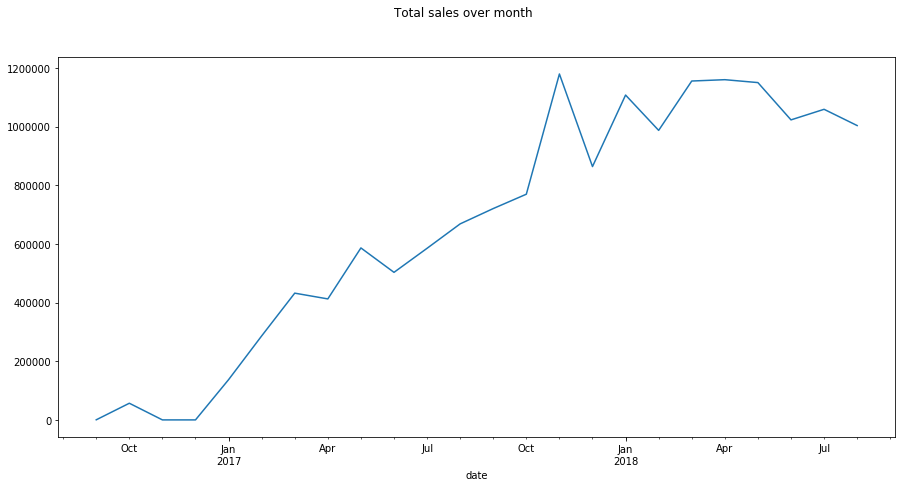

In [83]:
#Plot monthly sales
fig, ax = plt.subplots(figsize=(15,7))
order4.plot(subplots = True, title='Total sales over month', ax= ax)
plt.show()

As we see above, our data does not follow any cyclic pattern.<br/> As for seasonality, we see a spike in November 2018. However, there is no data for November 2017. So we can't establish the seasonlity yet. But we can definately see an increasing trend.<br/>
The problem with above sampling is we do not have November and December data points for year 2017.
<br/>
Let's sample our data weekly and see the distribustion:

In [54]:
#Aggregate sales weekly
order5 = order3['Total Price'].resample('W').sum()


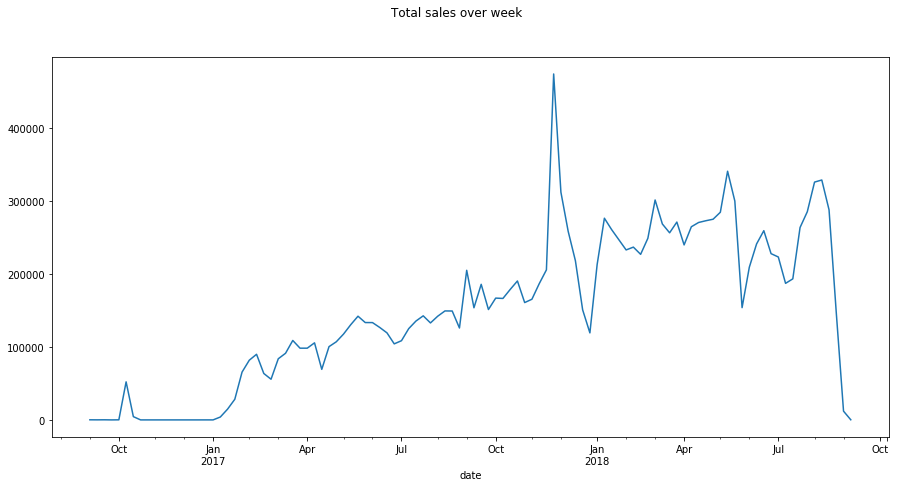

In [55]:
#Plot weekly sales
fig, ax = plt.subplots(figsize=(15,7))
order5.plot(subplots = True, title='Total sales over week')
plt.show()

Here, we have more data points and much clearer pattern.
Let's start predicting sales on that.

## Approach 1:

This is generic method where we use previous days sales to predict future sales.This is called as window shifting method
This method is referred from this blog: https://www.kaggle.com/carmnejsu/sales-forecast-lstm-67-beginner-friendly/notebook

In [61]:
order5 = order5.to_frame()

In [62]:
order5 = order5[:-1]

#### Here we have used shift() function to shift data points by n.
#### So for Y(n+1 ), X(x1,x2,..xn) would be last n weeks data points.

In [63]:
## Shift data by 5 weeks in past
look_back = 5
for obs in range(1,look_back+1):
    order5["Week_" + str(obs)] = order5['Total Price'].shift(obs)

In [64]:
# Fill shifted values by 0
order5.fillna(0.00,inplace=True)
order5.head(10)

,Total Price,Week_1,Week_2,Week_3,Week_4,Week_5
date,,,,,,
2016-09-04,136.23,0.00,0.00,0.00,0.00,0.00
2016-09-11,75.06,136.23,0.00,0.00,0.00,0.00
2016-09-18,143.46,75.06,136.23,0.00,0.00,0.00
2016-09-25,0.00,143.46,75.06,136.23,0.00,0.00
2016-10-02,109.34,0.00,143.46,75.06,136.23,0.00
2016-10-09,52206.11,109.34,0.00,143.46,75.06,136.23
2016-10-16,4493.39,52206.11,109.34,0.00,143.46,75.06
2016-10-23,0.00,4493.39,52206.11,109.34,0.00,143.46
2016-10-30,0.00,0.00,4493.39,52206.11,109.34,0.00


In [65]:
order5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 2016-09-04 to 2018-09-02
Freq: W-SUN
Data columns (total 6 columns):
Total Price    105 non-null float64
Week_1         105 non-null float64
Week_2         105 non-null float64
Week_3         105 non-null float64
Week_4         105 non-null float64
Week_5         105 non-null float64
dtypes: float64(6)
memory usage: 5.7 KB


Now we have 105 data points, we will divide dataset into 80%(train) and 20%(test) dataframes.

Here we will keep last 30 data points for testing and 75 data points for training.

In [66]:
#Split train data in X and Y
train_df = order5[:-30]
x_train_weekly,y_train_weekly = train_df.drop(["Total Price"],axis=1),train_df["Total Price"]

In [67]:
#Split test data in X and Y
test_df = order5[-30:]
x_test_weekly, y_test_weekly = test_df.drop(["Total Price"], axis=1), test_df["Total Price"]

In [68]:
x_train_weekly

,Week_1,Week_2,Week_3,Week_4,Week_5
date,,,,,
2016-09-04,0.00,0.00,0.00,0.00,0.00
2016-09-11,136.23,0.00,0.00,0.00,0.00
2016-09-18,75.06,136.23,0.00,0.00,0.00
2016-09-25,143.46,75.06,136.23,0.00,0.00
2016-10-02,0.00,143.46,75.06,136.23,0.00
2016-10-09,109.34,0.00,143.46,75.06,136.23
2016-10-16,52206.11,109.34,0.00,143.46,75.06
2016-10-23,4493.39,52206.11,109.34,0.00,143.46
2016-10-30,0.00,4493.39,52206.11,109.34,0.00


In [69]:
x_test_weekly

,Week_1,Week_2,Week_3,Week_4,Week_5
date,,,,,
2018-02-11,233194.99,247148.21,261083.57,276725.03,213191.43
2018-02-18,237063.52,233194.99,247148.21,261083.57,276725.03
2018-02-25,227164.57,237063.52,233194.99,247148.21,261083.57
2018-03-04,249189.92,227164.57,237063.52,233194.99,247148.21
2018-03-11,301730.51,249189.92,227164.57,237063.52,233194.99
2018-03-18,268805.00,301730.51,249189.92,227164.57,237063.52
2018-03-25,256711.67,268805.00,301730.51,249189.92,227164.57
2018-04-01,271435.79,256711.67,268805.00,301730.51,249189.92
2018-04-08,240082.46,271435.79,256711.67,268805.00,301730.51


We need to scale dataset in order to reduce variance. 

To achieve that we will use StandardScaler() to standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples, and s is the standard deviation of the training samples.

In [70]:
#Scale data
scaler = StandardScaler()
X_train_scaled_w =  scaler.fit_transform(x_train_weekly)
X_test_scaled_w =  scaler.fit_transform(x_test_weekly)

In [71]:
X_test_scaled_w

array([[-0.46420242, -0.25802265,  0.10278495,  0.55641079, -1.02726294],
       [-0.37970008, -0.59637131, -0.23828802,  0.15327002,  0.68236228],
       [-0.59592808, -0.50256415, -0.57979811, -0.20589797,  0.26146634],
       [-0.1148167 , -0.74260168, -0.48511445, -0.56552628, -0.11352017],
       [ 1.03285521, -0.20851365, -0.72739482, -0.46581934, -0.48898728],
       [ 0.31364587,  1.06553192, -0.18831643, -0.72095347, -0.38488903],
       [ 0.04948486,  0.26712824,  1.09763348, -0.15327523, -0.65125981],
       [ 0.37111161, -0.02612034,  0.29176973,  1.20089849, -0.05857981],
       [-0.31375577,  0.33092171, -0.00421888,  0.35228106,  1.35523457],
       [ 0.23060442, -0.42935851,  0.35615927,  0.04058929,  0.46924225],
       [ 0.35863305,  0.17494284, -0.4112248 ,  0.42008667,  0.14382291],
       [ 0.41105556,  0.3170691 ,  0.19872298, -0.38800961,  0.54003416],
       [ 0.45639617,  0.37526401,  0.34217723,  0.25429787, -0.30365239],
       [ 0.66554097,  0.42559722,  0.4

LSTM models take input in 3D format: [samples, time steps, features].

- Samples: These are independent observations from the domain, typically rows of data.
- Time steps: These are separate time steps of a given variable for a given observation.
- Features: These are separate measures observed at the time of observation.

In [72]:
#Reshape data
X_train_reshaped_w = X_train_scaled_w.reshape((X_train_scaled_w.shape[0], 1, X_train_scaled_w.shape[1]))
X_test_resaped_w = X_test_scaled_w.reshape((X_test_scaled_w.shape[0], 1, X_test_scaled_w.shape[1]))

In [73]:
X_test_resaped_w

array([[[-0.46420242, -0.25802265,  0.10278495,  0.55641079,
         -1.02726294]],

       [[-0.37970008, -0.59637131, -0.23828802,  0.15327002,
          0.68236228]],

       [[-0.59592808, -0.50256415, -0.57979811, -0.20589797,
          0.26146634]],

       [[-0.1148167 , -0.74260168, -0.48511445, -0.56552628,
         -0.11352017]],

       [[ 1.03285521, -0.20851365, -0.72739482, -0.46581934,
         -0.48898728]],

       [[ 0.31364587,  1.06553192, -0.18831643, -0.72095347,
         -0.38488903]],

       [[ 0.04948486,  0.26712824,  1.09763348, -0.15327523,
         -0.65125981]],

       [[ 0.37111161, -0.02612034,  0.29176973,  1.20089849,
         -0.05857981]],

       [[-0.31375577,  0.33092171, -0.00421888,  0.35228106,
          1.35523457]],

       [[ 0.23060442, -0.42935851,  0.35615927,  0.04058929,
          0.46924225]],

       [[ 0.35863305,  0.17494284, -0.4112248 ,  0.42008667,
          0.14382291]],

       [[ 0.41105556,  0.3170691 ,  0.19872298, -0.388

Let's build the model using:
layer = LSTM(neurons, input_shape=(X.shape[1], X.shape[2]))

Neurons are memory units.This is a very small dataset and a number between 1 and 5 should suffice.

The network requires a single neuron in the output layer with a linear activation(Default) to predict the sales at the next time step. This is given by:
keras.layers.Dense(units, activation=None)

We also must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE, and the efficient ADAM optimization algorithm.

In [74]:
#Build model
model_weekly = Sequential()
model_weekly.add(LSTM(4, input_shape = (1, look_back)))
model_weekly.add(Dense(1))
model_weekly.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

#### Now we fit the reshaped data by giving epochs(repetations) and batch size(no. of data points in each batch)

By keeping shuffle=False we do not shuffle traing inputs and verbose=2 will enable information about the learning progress.

In [75]:
#Fit model
fit_weekly = model_weekly.fit(X_train_reshaped_w, y_train_weekly ,validation_data=(X_test_resaped_w, y_test_weekly),
epochs=100, batch_size=1, verbose=2, shuffle=False)

Train on 75 samples, validate on 30 samples
Epoch 1/100
 - 1s - loss: 20872381729.4667 - acc: 0.1467 - val_loss: 65030784646.9333 - val_acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 20872348630.0815 - acc: 0.1467 - val_loss: 65030738604.2667 - val_acc: 0.0000e+00
Epoch 3/100
 - 0s - loss: 20872316041.0402 - acc: 0.1467 - val_loss: 65030688322.1333 - val_acc: 0.0000e+00
Epoch 4/100
 - 0s - loss: 20872277434.6904 - acc: 0.1467 - val_loss: 65030632023.4667 - val_acc: 0.0000e+00
Epoch 5/100
 - 0s - loss: 20872233356.6337 - acc: 0.1467 - val_loss: 65030572917.8667 - val_acc: 0.0000e+00
Epoch 6/100
 - 0s - loss: 20872182153.6227 - acc: 0.1467 - val_loss: 65030502886.4000 - val_acc: 0.0000e+00
Epoch 7/100
 - 0s - loss: 20872124260.1976 - acc: 0.1467 - val_loss: 65030426700.8000 - val_acc: 0.0000e+00
Epoch 8/100
 - 0s - loss: 20872060153.6926 - acc: 0.1333 - val_loss: 65030340669.8667 - val_acc: 0.0000e+00
Epoch 9/100
 - 0s - loss: 20871988412.8553 - acc: 0.1333 - val_loss: 65030249276.2667 - val_

Epoch 74/100
 - 0s - loss: 20868086852.6398 - acc: 0.0000e+00 - val_loss: 65021435644.8000 - val_acc: 0.0000e+00
Epoch 75/100
 - 0s - loss: 20868032427.5632 - acc: 0.0000e+00 - val_loss: 65021315164.8000 - val_acc: 0.0000e+00
Epoch 76/100
 - 0s - loss: 20867978526.7898 - acc: 0.0000e+00 - val_loss: 65021197482.1333 - val_acc: 0.0000e+00
Epoch 77/100
 - 0s - loss: 20867925296.2534 - acc: 0.0000e+00 - val_loss: 65021078309.3333 - val_acc: 0.0000e+00
Epoch 78/100
 - 0s - loss: 20867871449.8366 - acc: 0.0000e+00 - val_loss: 65020959962.6667 - val_acc: 0.0000e+00
Epoch 79/100
 - 0s - loss: 20867817918.6287 - acc: 0.0000e+00 - val_loss: 65020840518.4000 - val_acc: 0.0000e+00
Epoch 80/100
 - 0s - loss: 20867764512.2469 - acc: 0.0000e+00 - val_loss: 65020724554.1333 - val_acc: 0.0000e+00
Epoch 81/100
 - 0s - loss: 20867710671.8902 - acc: 0.0000e+00 - val_loss: 65020605995.7333 - val_acc: 0.0000e+00
Epoch 82/100
 - 0s - loss: 20867657613.5076 - acc: 0.0000e+00 - val_loss: 65020487915.2000 - val

#### Let's plot the loss

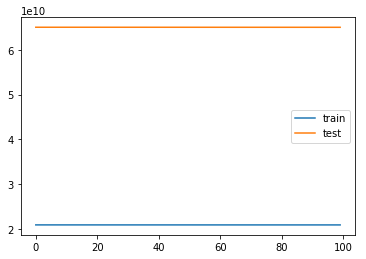

In [76]:
#Plot loss
plt.plot(fit_weekly.history['loss'], label='train')
plt.plot(fit_weekly.history['val_loss'], label='test')
plt.legend()

As expected from loss values, above graph shows huge loss in both training and testing which does not improve with number of epochs.
This shows that model is saturated and won't improve with increase in number of epochs.

Clearly, we need to improve our model.

## Let's check if number of data points is affecting the accuracy and sample data by a day.

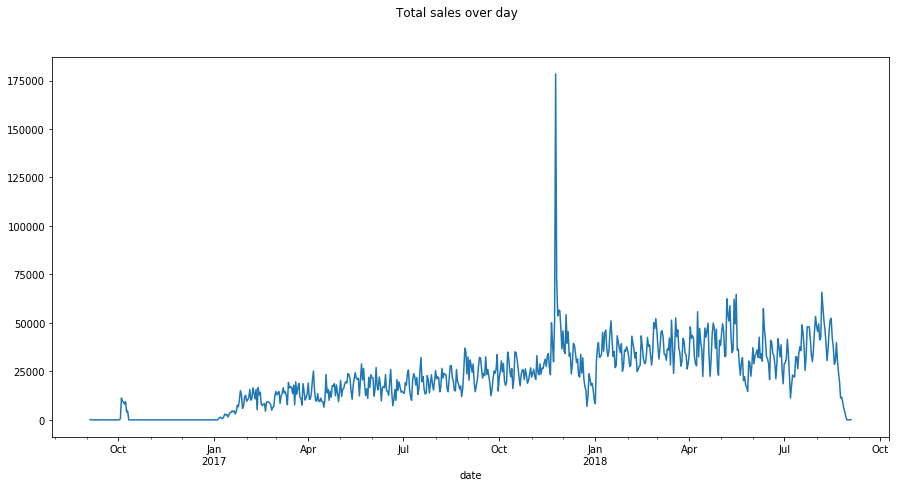

In [77]:
#Sample data daily
order6 = order3['Total Price'].resample('D').sum()

fig, ax = plt.subplots(figsize=(15,7))
order6.plot(subplots = True, title='Total sales over day')
plt.show()

In [78]:
order6 = order6.to_frame()
#order6.to_csv('daily_data.csv')

In [79]:
look_back=5
for obs in range(1,look_back+1):
    order6["Day_" + str(obs)] = order6['Total Price'].shift(obs)
    order6.fillna(0.00,inplace=True)
order6.head(10)

,Total Price,Day_1,Day_2,Day_3,Day_4,Day_5
date,,,,,,
2016-09-04,136.23,0.00,0.00,0.00,0.00,0.00
2016-09-05,75.06,136.23,0.00,0.00,0.00,0.00
2016-09-06,0.00,75.06,136.23,0.00,0.00,0.00
2016-09-07,0.00,0.00,75.06,136.23,0.00,0.00
2016-09-08,0.00,0.00,0.00,75.06,136.23,0.00
2016-09-09,0.00,0.00,0.00,0.00,75.06,136.23
2016-09-10,0.00,0.00,0.00,0.00,0.00,75.06
2016-09-11,0.00,0.00,0.00,0.00,0.00,0.00
2016-09-12,0.00,0.00,0.00,0.00,0.00,0.00


In [80]:
order6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2016-09-04 to 2018-09-03
Freq: D
Data columns (total 6 columns):
Total Price    730 non-null float64
Day_1          730 non-null float64
Day_2          730 non-null float64
Day_3          730 non-null float64
Day_4          730 non-null float64
Day_5          730 non-null float64
dtypes: float64(6)
memory usage: 39.9 KB


In [81]:
#Split into traing and testing
train_df_daily = order6[:-140]
x_train_daily,y_train_daily = train_df_daily.drop(["Total Price"],axis=1),train_df_daily["Total Price"]
test_df_daily = order6[-140:]
x_test_daily, y_test_daily = test_df_daily.drop(["Total Price"], axis=1), test_df_daily["Total Price"]

In [148]:
train_df_daily.shape

(590, 6)

Now let's scale and reshape data:

In [82]:
scaler = StandardScaler()
X_train_scaled_d =  scaler.fit_transform(x_train_daily)
X_test_scaled_d =  scaler.fit_transform(x_test_daily)

In [83]:
X_train_scaled_d.shape

(590, 5)

In [84]:
X_train_reshaped_d = X_train_scaled_d.reshape((X_train_scaled_d.shape[0], 1 , X_train_scaled_d.shape[1]))
X_test_resaped_d = X_test_scaled_d.reshape((X_test_scaled_d.shape[0],1, X_test_scaled_d.shape[1]))

In [85]:
X_train_reshaped_d.shape

(590, 1, 5)

Again build the model as explained previously:

In [86]:
model_daily = Sequential()
model_daily.add(LSTM(4, input_shape = (1,look_back)))
model_daily.add(Dense(1))
model_daily.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [87]:
fit_daily = model_daily.fit(X_train_reshaped_d, y_train_daily,validation_data=(X_test_resaped_d, y_test_daily),
epochs=100, batch_size=1, verbose=2, shuffle=False)

Train on 590 samples, validate on 140 samples
Epoch 1/100
 - 2s - loss: 593345832.1254 - acc: 0.1864 - val_loss: 1357259602.9442 - val_acc: 0.0000e+00
Epoch 2/100
 - 1s - loss: 593279794.2597 - acc: 0.0000e+00 - val_loss: 1357131746.4685 - val_acc: 0.0000e+00
Epoch 3/100
 - 1s - loss: 593196067.0138 - acc: 0.0000e+00 - val_loss: 1356990849.1533 - val_acc: 0.0000e+00
Epoch 4/100
 - 1s - loss: 593118444.7911 - acc: 0.0000e+00 - val_loss: 1356847817.3969 - val_acc: 0.0000e+00
Epoch 5/100
 - 1s - loss: 593040179.4872 - acc: 0.0000e+00 - val_loss: 1356696217.4753 - val_acc: 0.0000e+00
Epoch 6/100
 - 1s - loss: 592961891.6596 - acc: 0.0000e+00 - val_loss: 1356549292.3650 - val_acc: 0.0000e+00
Epoch 7/100
 - 1s - loss: 592886726.2101 - acc: 0.0000e+00 - val_loss: 1356411039.6251 - val_acc: 0.0000e+00
Epoch 8/100
 - 1s - loss: 592812920.0028 - acc: 0.0000e+00 - val_loss: 1356271372.2934 - val_acc: 0.0000e+00
Epoch 9/100
 - 1s - loss: 592740202.7007 - acc: 0.0000e+00 - val_loss: 1356137190.2309

Epoch 76/100
 - 1s - loss: 588131815.9446 - acc: 0.0000e+00 - val_loss: 1347740619.7306 - val_acc: 0.0000e+00
Epoch 77/100
 - 1s - loss: 588063399.2259 - acc: 0.0000e+00 - val_loss: 1347615705.7863 - val_acc: 0.0000e+00
Epoch 78/100
 - 1s - loss: 587995001.9121 - acc: 0.0000e+00 - val_loss: 1347490966.9114 - val_acc: 0.0000e+00
Epoch 79/100
 - 1s - loss: 587926622.4643 - acc: 0.0000e+00 - val_loss: 1347366264.2616 - val_acc: 0.0000e+00
Epoch 80/100
 - 1s - loss: 587858248.6396 - acc: 0.0000e+00 - val_loss: 1347241539.1869 - val_acc: 0.0000e+00
Epoch 81/100
 - 1s - loss: 587789890.3126 - acc: 0.0000e+00 - val_loss: 1347116682.2946 - val_acc: 0.0000e+00
Epoch 82/100
 - 1s - loss: 587721539.5549 - acc: 0.0000e+00 - val_loss: 1346991979.6189 - val_acc: 0.0000e+00
Epoch 83/100
 - 1s - loss: 587653208.4642 - acc: 0.0000e+00 - val_loss: 1346867296.9812 - val_acc: 0.0000e+00
Epoch 84/100
 - 1s - loss: 587584870.5627 - acc: 0.0000e+00 - val_loss: 1346742634.4169 - val_acc: 0.0000e+00
Epoch 85/1

Here we see the loss is reduced to half than weekly data but not as desired. 

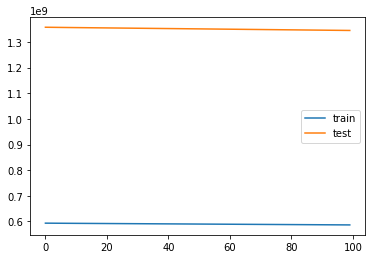

In [88]:
#Plot loss
plt.plot(fit_daily.history['loss'], label='train')
plt.plot(fit_daily.history['val_loss'], label='test')
plt.legend()

Calculate the RMSE

In [89]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt

y_pred_d = model_daily.predict(X_test_resaped_d)
rmse = sqrt(mean_squared_error(y_test_daily,y_pred_d))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 36670.819


In [90]:
import secrets
neurons= [4,10,20]
epochs= [50, 300]

def rmse(model, Xtest, Ytest):
    y_pred = model.predict(Xtest)
    rmse = sqrt(mean_squared_error(Ytest,y_pred))
    return rmse

## Let's write grid search for hyperparameter tuning

In [91]:
def gridsearch():
    repeats=4
    loop=[]
    
    for i in range(repeats):
        #Build model
        model_daily = Sequential()
        #Get random neurons and epochs
        n= secrets.choice(neurons)
        e= secrets.choice(epochs)
        #Build model
        model_daily.add(LSTM(n, input_shape = (1,look_back)))
        model_daily.add(Dense(1))
        #Add metrices
        model_daily.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
        #Fit model
        fit_daily_i = model_daily.fit(X_train_reshaped_d, y_train_daily,validation_data=(X_test_resaped_d, y_test_daily),epochs=e, batch_size=1, verbose=2, shuffle=False)
        #Get rmse
        loop_i = [i,rmse(model_daily,X_test_resaped_d, y_test_daily),n,e]
        loop.append( loop_i )
    print(loop)

In [92]:
gridsearch()

Train on 590 samples, validate on 140 samples
Epoch 1/50
 - 2s - loss: 593326373.1879 - acc: 0.1864 - val_loss: 1357144661.7122 - val_acc: 0.0000e+00
Epoch 2/50
 - 1s - loss: 593105663.6999 - acc: 0.0000e+00 - val_loss: 1356715723.1870 - val_acc: 0.0000e+00
Epoch 3/50
 - 1s - loss: 592853572.4952 - acc: 0.0000e+00 - val_loss: 1356319155.0092 - val_acc: 0.0000e+00
Epoch 4/50
 - 1s - loss: 592654222.7071 - acc: 0.0000e+00 - val_loss: 1355942487.8943 - val_acc: 0.0143
Epoch 5/50
 - 1s - loss: 592462286.8618 - acc: 0.0000e+00 - val_loss: 1355564382.6585 - val_acc: 0.0000e+00
Epoch 6/50
 - 1s - loss: 592285690.1630 - acc: 0.0000e+00 - val_loss: 1355243981.4309 - val_acc: 0.0000e+00
Epoch 7/50
 - 1s - loss: 592127149.3319 - acc: 0.0000e+00 - val_loss: 1354958391.0940 - val_acc: 0.0000e+00
Epoch 8/50
 - 1s - loss: 591975257.6222 - acc: 0.0000e+00 - val_loss: 1354679485.9547 - val_acc: 0.0000e+00
Epoch 9/50
 - 1s - loss: 591825659.6630 - acc: 0.0000e+00 - val_loss: 1354406638.3894 - val_acc: 0

Epoch 26/300
 - 1s - loss: 585780816.1928 - acc: 0.0000e+00 - val_loss: 1343263022.9859 - val_acc: 0.0000e+00
Epoch 27/300
 - 1s - loss: 585507755.2932 - acc: 0.0000e+00 - val_loss: 1342764128.1564 - val_acc: 0.0000e+00
Epoch 28/300
 - 1s - loss: 585234927.4933 - acc: 0.0000e+00 - val_loss: 1342265452.3143 - val_acc: 0.0000e+00
Epoch 29/300
 - 1s - loss: 584962240.8974 - acc: 0.0000e+00 - val_loss: 1341766928.9101 - val_acc: 0.0000e+00
Epoch 30/300
 - 1s - loss: 584689729.8009 - acc: 0.0000e+00 - val_loss: 1341268559.7504 - val_acc: 0.0000e+00
Epoch 31/300
 - 1s - loss: 584417362.7559 - acc: 0.0000e+00 - val_loss: 1340770479.9640 - val_acc: 0.0000e+00
Epoch 32/300
 - 1s - loss: 584145146.5385 - acc: 0.0000e+00 - val_loss: 1340272533.3818 - val_acc: 0.0000e+00
Epoch 33/300
 - 1s - loss: 583873079.1755 - acc: 0.0000e+00 - val_loss: 1339774751.4335 - val_acc: 0.0000e+00
Epoch 34/300
 - 1s - loss: 583601169.0922 - acc: 0.0000e+00 - val_loss: 1339277247.2792 - val_acc: 0.0000e+00
Epoch 35/3

Epoch 101/300
 - 1s - loss: 565728064.7550 - acc: 0.0000e+00 - val_loss: 1306368780.9585 - val_acc: 0.0000e+00
Epoch 102/300
 - 1s - loss: 565466412.7230 - acc: 0.0000e+00 - val_loss: 1305883860.0888 - val_acc: 0.0000e+00
Epoch 103/300
 - 1s - loss: 565204921.4328 - acc: 0.0000e+00 - val_loss: 1305399242.0879 - val_acc: 0.0000e+00
Epoch 104/300
 - 1s - loss: 564943570.9744 - acc: 0.0000e+00 - val_loss: 1304914905.5223 - val_acc: 0.0000e+00
Epoch 105/300
 - 1s - loss: 564682355.5701 - acc: 0.0000e+00 - val_loss: 1304430553.5627 - val_acc: 0.0000e+00
Epoch 106/300
 - 1s - loss: 564421300.6172 - acc: 0.0000e+00 - val_loss: 1303946501.7837 - val_acc: 0.0000e+00
Epoch 107/300
 - 1s - loss: 564160403.2405 - acc: 0.0000e+00 - val_loss: 1303462606.6574 - val_acc: 0.0000e+00
Epoch 108/300
 - 1s - loss: 563899685.2389 - acc: 0.0000e+00 - val_loss: 1302978998.8616 - val_acc: 0.0000e+00
Epoch 109/300
 - 1s - loss: 563639092.8751 - acc: 0.0000e+00 - val_loss: 1302495528.1665 - val_acc: 0.0000e+00
E

Epoch 175/300
 - 1s - loss: 546769182.1110 - acc: 0.0000e+00 - val_loss: 1270997670.9190 - val_acc: 0.0000e+00
Epoch 176/300
 - 2s - loss: 546518565.5004 - acc: 0.0000e+00 - val_loss: 1270526784.4373 - val_acc: 0.0000e+00
Epoch 177/300
 - 1s - loss: 546268103.9277 - acc: 0.0000e+00 - val_loss: 1270056041.4941 - val_acc: 0.0000e+00
Epoch 178/300
 - 1s - loss: 546017788.3042 - acc: 0.0000e+00 - val_loss: 1269585444.2375 - val_acc: 0.0000e+00
Epoch 179/300
 - 1s - loss: 545767593.6892 - acc: 0.0000e+00 - val_loss: 1269114920.7155 - val_acc: 0.0000e+00
Epoch 180/300
 - 1s - loss: 545517552.5156 - acc: 0.0000e+00 - val_loss: 1268644729.7285 - val_acc: 0.0000e+00
Epoch 181/300
 - 1s - loss: 545267630.4442 - acc: 0.0000e+00 - val_loss: 1268174638.0989 - val_acc: 0.0000e+00
Epoch 182/300
 - 1s - loss: 545017834.3009 - acc: 0.0000e+00 - val_loss: 1267704669.7075 - val_acc: 0.0000e+00
Epoch 183/300
 - 1s - loss: 544768167.4704 - acc: 0.0000e+00 - val_loss: 1267234816.0406 - val_acc: 0.0000e+00
E

Epoch 249/300
 - 1s - loss: 528619031.5928 - acc: 0.0000e+00 - val_loss: 1236647394.2182 - val_acc: 0.0000e+00
Epoch 250/300
 - 1s - loss: 528379206.9748 - acc: 0.0000e+00 - val_loss: 1236190122.9970 - val_acc: 0.0000e+00
Epoch 251/300
 - 1s - loss: 528139514.4546 - acc: 0.0000e+00 - val_loss: 1235732998.2458 - val_acc: 0.0000e+00
Epoch 252/300
 - 1s - loss: 527899948.9104 - acc: 0.0000e+00 - val_loss: 1235275978.9804 - val_acc: 0.0000e+00
Epoch 253/300
 - 1s - loss: 527660520.9456 - acc: 0.0000e+00 - val_loss: 1234819213.7326 - val_acc: 0.0000e+00
Epoch 254/300
 - 1s - loss: 527421222.1302 - acc: 0.0000e+00 - val_loss: 1234362588.9113 - val_acc: 0.0000e+00
Epoch 255/300
 - 1s - loss: 527182060.3805 - acc: 0.0000e+00 - val_loss: 1233906072.1214 - val_acc: 0.0000e+00
Epoch 256/300
 - 1s - loss: 526943034.2044 - acc: 0.0000e+00 - val_loss: 1233449714.2340 - val_acc: 0.0000e+00
Epoch 257/300
 - 1s - loss: 526704140.3759 - acc: 0.0000e+00 - val_loss: 1232993595.7865 - val_acc: 0.0000e+00
E

Epoch 23/300
 - 1s - loss: 591683106.2800 - acc: 0.0000e+00 - val_loss: 1354211862.9501 - val_acc: 0.0000e+00
Epoch 24/300
 - 1s - loss: 591614204.7859 - acc: 0.0000e+00 - val_loss: 1354086362.4056 - val_acc: 0.0000e+00
Epoch 25/300
 - 1s - loss: 591545318.7668 - acc: 0.0000e+00 - val_loss: 1353961030.5282 - val_acc: 0.0000e+00
Epoch 26/300
 - 1s - loss: 591476983.0960 - acc: 0.0000e+00 - val_loss: 1353835522.0506 - val_acc: 0.0000e+00
Epoch 27/300
 - 1s - loss: 591407827.4809 - acc: 0.0000e+00 - val_loss: 1353710320.3424 - val_acc: 0.0000e+00
Epoch 28/300
 - 1s - loss: 591338787.0837 - acc: 0.0000e+00 - val_loss: 1353585133.3321 - val_acc: 0.0000e+00
Epoch 29/300
 - 1s - loss: 591269862.1937 - acc: 0.0000e+00 - val_loss: 1353459802.8810 - val_acc: 0.0000e+00
Epoch 30/300
 - 1s - loss: 591201023.9990 - acc: 0.0000e+00 - val_loss: 1353334450.4576 - val_acc: 0.0000e+00
Epoch 31/300
 - 1s - loss: 591132186.4614 - acc: 0.0000e+00 - val_loss: 1353209037.7440 - val_acc: 0.0000e+00
Epoch 32/3

Epoch 98/300
 - 1s - loss: 586542313.7913 - acc: 0.0000e+00 - val_loss: 1344836540.1528 - val_acc: 0.0000e+00
Epoch 99/300
 - 1s - loss: 586474136.2660 - acc: 0.0000e+00 - val_loss: 1344711970.3706 - val_acc: 0.0000e+00
Epoch 100/300
 - 1s - loss: 586405958.6047 - acc: 0.0000e+00 - val_loss: 1344587431.2512 - val_acc: 0.0000e+00
Epoch 101/300
 - 1s - loss: 586337804.4271 - acc: 0.0000e+00 - val_loss: 1344462870.6747 - val_acc: 0.0000e+00
Epoch 102/300
 - 1s - loss: 586269646.0460 - acc: 0.0000e+00 - val_loss: 1344338323.1001 - val_acc: 0.0000e+00
Epoch 103/300
 - 1s - loss: 586201502.5613 - acc: 0.0000e+00 - val_loss: 1344213805.3794 - val_acc: 0.0000e+00
Epoch 104/300
 - 1s - loss: 586133378.3388 - acc: 0.0000e+00 - val_loss: 1344089439.2592 - val_acc: 0.0000e+00
Epoch 105/300
 - 1s - loss: 586065240.3158 - acc: 0.0000e+00 - val_loss: 1343964940.6283 - val_acc: 0.0000e+00
Epoch 106/300
 - 1s - loss: 585997133.8488 - acc: 0.0000e+00 - val_loss: 1343840420.4854 - val_acc: 0.0000e+00
Epo

Epoch 172/300
 - 1s - loss: 581521675.1312 - acc: 0.0000e+00 - val_loss: 1335650171.1722 - val_acc: 0.0000e+00
Epoch 173/300
 - 1s - loss: 581454188.3053 - acc: 0.0000e+00 - val_loss: 1335526403.3253 - val_acc: 0.0000e+00
Epoch 174/300
 - 1s - loss: 581386714.7784 - acc: 0.0000e+00 - val_loss: 1335402796.5582 - val_acc: 0.0000e+00
Epoch 175/300
 - 1s - loss: 581319240.0922 - acc: 0.0000e+00 - val_loss: 1335279044.9475 - val_acc: 0.0000e+00
Epoch 176/300
 - 1s - loss: 581251783.6766 - acc: 0.0000e+00 - val_loss: 1335155467.7580 - val_acc: 0.0000e+00
Epoch 177/300
 - 1s - loss: 581184331.6066 - acc: 0.0000e+00 - val_loss: 1335031749.2338 - val_acc: 0.0000e+00
Epoch 178/300
 - 1s - loss: 581116901.1596 - acc: 0.0000e+00 - val_loss: 1334908185.4951 - val_acc: 0.0000e+00
Epoch 179/300
 - 1s - loss: 581049471.6707 - acc: 0.0000e+00 - val_loss: 1334784459.1590 - val_acc: 0.0000e+00
Epoch 180/300
 - 1s - loss: 580982049.9420 - acc: 0.0000e+00 - val_loss: 1334660906.8863 - val_acc: 0.0000e+00
E

Epoch 246/300
 - 1s - loss: 576552371.3423 - acc: 0.0000e+00 - val_loss: 1326527011.3329 - val_acc: 0.0000e+00
Epoch 247/300
 - 1s - loss: 576485549.2471 - acc: 0.0000e+00 - val_loss: 1326404169.3682 - val_acc: 0.0000e+00
Epoch 248/300
 - 1s - loss: 576418741.8775 - acc: 0.0000e+00 - val_loss: 1326281363.3040 - val_acc: 0.0000e+00
Epoch 249/300
 - 1s - loss: 576351941.1524 - acc: 0.0000e+00 - val_loss: 1326158540.8314 - val_acc: 0.0000e+00
Epoch 250/300
 - 1s - loss: 576285155.6774 - acc: 0.0000e+00 - val_loss: 1326035581.1950 - val_acc: 0.0000e+00
Epoch 251/300
 - 1s - loss: 576218371.5107 - acc: 0.0000e+00 - val_loss: 1325912772.4107 - val_acc: 0.0000e+00
Epoch 252/300
 - 1s - loss: 576151603.3691 - acc: 0.0000e+00 - val_loss: 1325789995.2206 - val_acc: 0.0000e+00
Epoch 253/300
 - 1s - loss: 576084845.3981 - acc: 0.0000e+00 - val_loss: 1325667221.6040 - val_acc: 0.0000e+00
Epoch 254/300
 - 1s - loss: 576018103.3478 - acc: 0.0000e+00 - val_loss: 1325544443.2887 - val_acc: 0.0000e+00
E

Epoch 20/50
 - 1s - loss: 590177379.5431 - acc: 0.0000e+00 - val_loss: 1351402038.3285 - val_acc: 0.0000e+00
Epoch 21/50
 - 1s - loss: 590031353.5681 - acc: 0.0000e+00 - val_loss: 1351135248.5312 - val_acc: 0.0000e+00
Epoch 22/50
 - 1s - loss: 589884856.2262 - acc: 0.0000e+00 - val_loss: 1350868825.5884 - val_acc: 0.0000e+00
Epoch 23/50
 - 1s - loss: 589738672.6528 - acc: 0.0000e+00 - val_loss: 1350602359.7175 - val_acc: 0.0000e+00
Epoch 24/50
 - 1s - loss: 589592825.1771 - acc: 0.0000e+00 - val_loss: 1350335858.1161 - val_acc: 0.0000e+00
Epoch 25/50
 - 1s - loss: 589446477.7353 - acc: 0.0000e+00 - val_loss: 1350069565.3733 - val_acc: 0.0000e+00
Epoch 26/50
 - 1s - loss: 589300449.3167 - acc: 0.0000e+00 - val_loss: 1349803252.3009 - val_acc: 0.0000e+00
Epoch 27/50
 - 1s - loss: 589154460.7277 - acc: 0.0000e+00 - val_loss: 1349537167.5401 - val_acc: 0.0000e+00
Epoch 28/50
 - 1s - loss: 589008514.9349 - acc: 0.0000e+00 - val_loss: 1349271173.5872 - val_acc: 0.0000e+00
Epoch 29/50
 - 1s -

According to results, RMSE observed for parameter combination is as follows:


  |   neurons    |    epochs   |    RMSE        |
  | --- | --- | --- |
  |     10       |      50     |    36653.62    |
  |     20       |      300    |    34836.22    |
  |     4        |      300    |    36330.55    |


It shows that changing values neurons and epochs is not going to help us in tuning this model.<br/> Since we have used a *secret library* they are totally random and it had chosen repeat values for neuron and epoch combination giving only 2 unique combinations.    